# Identification of Best Model 


## Setup

In [1]:
import pickle
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import seaborn as sns

# import Utilities
import importlib
# importlib.reload(Utilities)

# import MLUtilities
# importlib.reload(MLUtilities)

from sklearn.pipeline import Pipeline


# from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.preprocessing import  MinMaxScaler
from sklearn.preprocessing import  OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier


# from hyperopt.pyll import scope
# from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK

from hyperopt import hp,Trials,fmin,tpe,STATUS_OK

import xgboost as xgb

from imblearn.over_sampling import SMOTENC

pd.set_option('display.max_columns', None)


plt.style.use('./CEIH.mplstyle')
color_dict = {0: to_rgba('#32C0D2', 1),
                1: to_rgba("#E0B165", 1),}

cmap_blended = sns.blend_palette(["#ADE6ED","#70D3E0","#32C0D2","#289AA8","#307078"], as_cmap=True)


# import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    

    
OtherValues = {'TriageCategory_2':'Triage Category 2', 'SoBFlag': 'Shortness of Breath', 'TriageCategory_4':'Triage Category 4',
               'TriageCategory_1':'Triage Category 1', 'TriageCategory_5':'Triage Category 5', 'TriageCategory_3':'Triage Category 3',
             'FirstGCSScoreAdult':'Glasgow Coma Scale',
               'FirstUrinalysisBlood': 'Urinalysis Blood', 'IndigenousStatusDescription_Not Aboriginal-TSI':  'Non Indiginous',
               'IndigenousStatusDescription_Not Stated':  'Indiginous Status not stated', 'FirstUrinalysisLeukocytes':'Urinalysis Leukocytes',
               'FirstPulseRateBPM':'Pulse Rate', 'FirstRespiration':'Respiration Rate', 'FirstSpO2':'O2 Saturation (%)',  'Gender_Male':'Sex - Male',
               'FirstLevelofConsciousness':'Level of Consciousness', 'IndigenousStatusDescription_Aboriginal and TSI':'Aboriginal and TSI',
               'IndigenousStatusDescription_TSI':'TSI','Gender_Indeterminate':'Sex - Indeterminate', 'Gender_Unknown':'Sex - Unknown',
               'FirstO2Flow':'O2 Flow ','GENDERCODE_Male':'Sex - Male','GENDERCODE_Unknown':'Sex - Unknown',
               'GENDERCODE_Indeterminate':'Sex - Indeterminate'
               }

plotSettings = {
        #  ( bins, xmin, xmax, log/linear)
        'AGEONADMISSION':(45,19.5,109.5,'linear','Age (y)', False, 0,0),
        
        
        'FirstBloodGlucose':(50,0,100,'log','Blood Glucose [mmol/L]', False,0, 0),
        'FirstTemperatureDegreesC':(50,30,45,'log', r"Temperature [$^\circ$C]", True,35.5,38.1),
                'FirstWeightKg':(50,50,150,'log','Weight [kg]', False, 0,0),

        
        'FirstPainAssessment': (11,-0.5,10.5,'log','Pain Assessment', False, 8,10),
        'FirstBPSystolic': (50,50,250,'log', 'BP Systolic [mm Hg]',True, 100,170 ),
        'FirstBPDiastolic': (50,0,200,'log', 'BP Diastolic [mm Hg]', False,0,0),
        'FirstEstimatedGlomerularFiltrationRate': (50,0,100,'log',r"Estimated Glomerular Filtration Rate [mL/min/1.73m$^{2}$]", True, 60, 100),
        'FirstCreatinine': (50,0,800,'log',r"Creatinine - Serum [$\mu$mol/L]", True, 45, 110),
        'FirstAlbumin': (60,0,60,'log','Albumin  Level [g/L]', True, 30, 48),
        'FirstTotalBilirubin': (60,0,100,'log',r"Total Bilirubin Level [$\mu$mol/L]", True, 2, 24 ),
        'FirstAlkalinePhosphatase': (60,0,800,'log','Alkaline Phosphatase Level [U/L]',True, 30,110),
        'FirstAlanineAminotransferase': (60,0,700,'log','Alanine Aminotransferase Level [U/L]', True,0,55),
        'FirstAspartateAminotransferase': (60,0,700,'log','Aspartate Aminotransferase Level [U/L]', True, 0,45),
        'FirstGammaGlutamylTransferase': (60,0,700,'log','Gamma Glutamyl Transferase Level [U/L]', True, 0, 60),
        'FirstLactateDehydrogenase': (60,0,1200,'log','Lactate Dehydrogenase [U/L]', True, 120, 250),
        'FirstHaemoglobin': (50,10, 220,'log','Haemoglobin [g/L]', True, 115, 175),
        'FirstWhiteCellCount': (50,0, 50,'log',r"White Cell Count [$\times 10^{9}$/L]",True, 4,11),
        'FirstPlateletCount': (50,0, 1000,'log',r"Platelet Count [$\times 10^{9}$/L]",True,150,500),
        'FirstNeutrophils': (50,0, 50,'log',r"Absolute Neutrophil Count [$\times 10^{9}$/L]",True,1.80,7.50),
        'FirstDDimer': (40,0, 20,'log',r"D-Dimer [mg/L]",True,0,0.79),
        'FirstCreactiveprotein': (50,0, 600,'log',r"C-Reactive Protein [mg/L]",True, 0,8),
        'FirstTroponinT': (50,0, 600,'log',r"Troponin T Level [mg/L]",True,0,16),
        'FirstNTproBNP': (50,0, 40000,'log',r"NT-pro Brain Natriuretic Peptide [mg/L]",True,0,124),
        
        'FirstAnionGapVenous': (50,0, 50,'log',r"Anion Gap Venous [mmol/L]", True, 7, 17),
        'FirstAnionGapArterial': (50,0, 50,'log',r"Anion Gap Arterial [mmol/L]",  True, 7, 17),
        'FirstBaseExcessVenous': (50,-30, 30,'log',r"Base Excess Venous [mmol/L]", True, -3, 3),
        'FirstBaseExcessArterial': (50,-30, 30,'log',r"Base Excess Arterial [mmol/L]", True, -3, 3),
        'FirstBilirubinVenous': (60,0, 60,'log',r"Bilirubin Venous [$\mu$mol/L]", True, 2,24),
        'FirstBilirubinArterial': (60,0, 60,'log',r"Bilirubin Arterial [$\mu$mol/L]", True, 2,24),
        'FirstCarboxyhaemoglobinVenous': (50,0, 20,'log',r"Carboxyhaemoglobin Venous [%]", True, 0.3, 1.8),
        'FirstCarboxyhaemoglobinArterial': (50,0, 20,'log',r"Carboxyhaemoglobin Arterial [%]", True, 0.3, 1.8),
        'FirstChlorideDirectVenous': (50,50, 150,'log',r"Chloride Direct Venous [mmol/L]",False, 100,109),
        'FirstChlorideDirectArterial': (50,50, 150,'log',r"Chloride Direct Arterial [mmol/L]", True, 100,109),
        'FirstCreatinineVenous':(50,0,500,'log',r"Creatinine Venous [$\mu$mol/L]", True, 50, 120),
        'FirstCreatinineArterial':(50,0,500,'log',r"Creatinine Arterial [$\mu$mol/L]", True, 50,120),
        'FirstGlucoseVenous':(50,0,30,'log',r"Glucose  Venous [mmol/L]", False,0,0),
        'FirstGlucoseArterial':(50,0,30,'log',r"Glucose  Arterial [mmol/L]", True,2.6,5.6),
        'FirstIonised Calcium Venous':(50,0,2,'log',r"Ionised Calcium Venous [mmol/L]", True, 1.1, 1.3),
        'FirstIonised Calcium Arterial':(50,0,2,'log',r"Ionised Calcium Arterial [mmol/L]", True, 1.1, 1.3),
        'FirstLactateVenous':(50,0,30,'log',r"Lactate Venous [mmol/L]", True, 0.2, 2.0),
        'FirstLactateArterial':(50,0,30,'log',r"Lactate Arterial [mmol/L]", True, 0.2, 2.0),
        'FirstMethaemoglobinVenous': (20,0, 3,'log',r"Methaemoglobin Venous [%]", True, 0.4, 1.2),
        'FirstMethaemoglobinArterial': (20,0, 3,'log',r"Methaemoglobin Arterial [%]", True, 0.2,0.6),
        'FirstOxygenSaturationVenous': (50,0, 100,'log',r"Oxygen Saturation Venous [%]", False, 0,0),
        'FirstOxygenSaturationArterial': (50,0, 100,'log',r"Oxygen Saturation Arterial [%]", True,95, 99),
        'FirstOxyhaemoglobinVenous': (50,0, 100,'log',r"Oxyhaemoglobin Venous [%]", False, 0,0),
        'FirstOxyhaemoglobinArterial': (50,0, 100,'log',r"Oxyhaemoglobin Arterial [%]", False, 0,0),
        'FirstReducedHaemoglobinVenous': (50,0, 100,'log',r"Reduced Haemoglobin Venous [%]", False, 0,0),
        'FirstReducedHaemoglobinArterial': (50,0, 100,'log',r"Reduced Haemoglobin Arterial [%]", False, 0,0),
        'FirstTotalHaemoglobinVenous': (50,10, 220,'log','Total Haemoglobin Venous [g/L]', True, 115,180),
        'FirstTotalHaemoglobinArterial': (50,10, 220,'log','Total Haemoglobin Arterial [g/L]', True, 115,180), 
        'FirstpCO2Venous': (50,0,150,'log', 'pCO2 Venous [mm Hg]', True,41,51),
        'FirstpCO2Arterial': (50,0,150,'log', 'pCO2 Arterial [mm Hg]', True, 35, 45 ),
        'FirstpO2Venous': (50,0,200,'log', 'pO2 Venous [mm Hg]', True, 25,40),
        'FirstpO2Arterial': (50,0,200,'log', 'pO2 Arterial [mm Hg]', True,67, 108),
        'FirstpHVenous': (50,6.8,7.8,'log', 'pH Venous', True, 7.32,7.42),
        'FirstpHArterial': (50,6.8,7.8,'log', 'pH Arterial', True, 7.36, 7.44),
        'FirstPotassiumDirectVenous':(50,0,10,'log',r"Potassium Direct Venous [mmol/L]", False, 0,0),
        'FirstPotassiumDirectArterial':(50,0,10,'log',r"Potassium Direct Arterial [mmol/L]", True, 3.1, 4.2),
        'FirstSodiumDirectVenous':(50,100,180,'log',r"Sodium Direct Venous [mmol/L]", False, 0,0),
        'FirstSodiumDirectArterial':(50,100,180,'log',r"Sodium Direct Arterial [mmol/L]", True, 137, 145),
        
        'FirstO2Flow':(20,0,20,'log',r"O$_{2}$ Flow", True,0,5),
        'FirstPulseRateBPM':(50,0,200,'log','Pulse Rate',True,60,100),
        'FirstSpO2':(50,0,100,'log',r"O$_{2}$ Saturation [%]",True,94,100),
         'FirstRespiration':(20,0,40,'log','Respiration Rate',True,10,21),
         'FirstLevelofConsciousness':(4,-0.5,3.5,'log',"Level of Consciousness",True,-0.5,2),
        'FirstGCSScoreAdult':(16,-0.5,15.5,'log','Glasgow Coma Scale',False,0,0)
        
        }


## Load Data

In [2]:
Data_Storage_File = 'Data\ED_Presentations_{}_{}_Version_01.pkl'.format(2023,2024)
print(Data_Storage_File)


with open(Data_Storage_File, 'rb') as file:
    sepsis_df = pd.read_pickle(file)



Data\ED_Presentations_2023_2024_Version_01.pkl


In [3]:
sepsis_df.columns

Index(['JOURNEY_ID', 'CLIENTGUID', 'VISITGUID', 'CHARTGUID', 'ADMITDTM',
       'DISCHARGEDTM', 'AGEONADMIT', 'TRIAGE_CATEGORY', 'DISCHARGEDISPOSITION',
       'HOSPITAL', 'FIRSTTRIAGEVALUE', 'GENDERCODE', 'RACECODE', 'DECEASEDDTM',
       'PRIMARY_SEPSIS', 'ANY_SEPSIS', 'VISITGUID_IP', 'CHARTGUID_IP',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'PRE_ADMITDTM', 'PRE_DISCHARGEDTM',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'AGEONADMIT_IP',
       'MORTALITY_INDICATOR', 'DISCHARGEDISPOSITION_IP', 'ALLCHARDIAGNOSIS',
       'CURRENTLOCATION', 'IP_ED_Overlap', 'HOSPITAL_IP',
       'VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL', 'AUTHOREDDTM', 'Purple zone',
       'Red zone', 'Yellow zone', 'Pulse Rate (beats/min)',
       'Temperature (degrees C)', 'BP Systolic (mm Hg)',
       'BP Diastolic (mm Hg)', 'O2 Flow (L/min)', 'Sedation Score',
       'Resting Pain Score', 'Respiration (breaths/min)',
       'Pain: New/Unexpected', 'SpO2 (%)', 'GCS Score', 'ICU_HOURS',
       'AGERANGE_ON_ADMIT2', 'Indig

## Setup for Machine Learning 

In [4]:
# Defaulkts

replaceValues ={
       'Pulse Rate (beats/min)':80,  # Not great.... what to put here, do I need it 
       'Temperature (degrees C)':37.5, 
       'BP Systolic (mm Hg)':120,
       # 'BP Diastolic (mm Hg)', 
       'O2 Flow (L/min)':0., 
       'Sedation Score':0,
       # 'Resting Pain Score', 
       'Respiration (breaths/min)':15,
       # 'Pain: New/Unexpected', 
       'SpO2 (%)':98,
       # 'GENDERCODE':'Unknown'
       
}  

In [5]:
# remove all with age over 120 if using 

DiagnosisString = 'ANY_SEPSIS'

AnalysisVariable =[ 
       'Pulse Rate (beats/min)',
       'Temperature (degrees C)', 
       'BP Systolic (mm Hg)',
       # 'BP Diastolic (mm Hg)', 
       'O2 Flow (L/min)', 
       'Sedation Score',
       # 'Resting Pain Score', 
       'Respiration (breaths/min)',
       # 'Pain: New/Unexpected', 
       'SpO2 (%)',
       'AGEONADMIT',
#        'GENDERCODE',
        DiagnosisString]
    

sepsis_df.dropna(subset=['NUMBER_NOT_NULL'],inplace=True)



sepsis_2023_df = sepsis_df.loc[sepsis_df.ADMITDTM.between('2023-01-01','2024-01-01')].copy()
sepsis_2023_df = sepsis_2023_df.loc[sepsis_2023_df.AGEONADMIT<120].copy()
sepsis_2023_df = sepsis_2023_df.loc[sepsis_2023_df.GENDERCODE!='Unknown'].copy()




In [6]:
sepsis_2023_df.GENDERCODE.value_counts()

GENDERCODE
Female           138164
Male             122441
Indeterminate        41
Name: count, dtype: int64

In [7]:
# Create ML Vector

df = sepsis_2023_df[AnalysisVariable].copy()

# df['Gender'] = np.where(sepsis_2023_df.GENDERCODE=='Male','Male','Female')

# Set defaults 

for key in replaceValues:  
    df[key] = df[key].fillna(replaceValues[key])
    print(key, df[key].dtype)
    if df[key].dtype=='object':
        # print('object***')
        df[key] = pd.to_numeric(df[key])


df.head()

Pulse Rate (beats/min) Int64
Temperature (degrees C) object
BP Systolic (mm Hg) Int64
O2 Flow (L/min) object
Sedation Score Int64
Respiration (breaths/min) Int64
SpO2 (%) Int64


,Pulse Rate (beats/min),Temperature (degrees C),BP Systolic (mm Hg),O2 Flow (L/min),Sedation Score,Respiration (breaths/min),SpO2 (%),AGEONADMIT,ANY_SEPSIS
0,81,37.5,141,0.0,0,22,98,50,0
1,64,36.4,105,0.0,0,18,98,48,0
2,79,37.5,138,0.0,0,18,100,54,0
3,131,37.0,126,0.0,0,30,95,22,0
4,98,35.9,154,0.0,0,18,99,68,0


In [8]:
# df.Gender.value_counts()

In [9]:
nan_counts = df.isnull().sum()
nan_counts

Pulse Rate (beats/min)       0
Temperature (degrees C)      0
BP Systolic (mm Hg)          0
O2 Flow (L/min)              0
Sedation Score               0
Respiration (breaths/min)    0
SpO2 (%)                     0
AGEONADMIT                   0
ANY_SEPSIS                   0
dtype: int64

In [10]:
sepsis_2023_df[sepsis_2023_df.ANY_SEPSIS==1].DISCHARGEDISPOSITION.value_counts()

DISCHARGEDISPOSITION
ED02 Admit as Inpatient                2291
ED03 Admit to EECU                      128
ED06 Transfer to Other Hospital         125
ED01 Discharged Home                      9
ED05 Left before treatment complete       2
ED04 Did not wait                         1
Name: count, dtype: int64

In [11]:
# sepsis_2023_df[(sepsis_2023_df.ANY_SEPSIS==1)&(sepsis_2023_df.DISCHARGEDISPOSITION=='ED01 Discharged Home')]

In [12]:
# sepsis_df.loc[(sepsis_df.AGEONADMIT>110)&(sepsis_df.AGEONADMIT<130)]   #.AGEONADMIT.value_counts()

In [13]:
n_est=55


numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),  # StandardScaler #MinMaxScaler # RobustScaler
        # ('scaler', RobustScaler(quantile_range=((25.0,75.0)))),  # StandardScaler #MinMaxScaler # RobustScaler
        #('skew', FunctionTransformer(log_transform))
    ])


space4xgbsepsis = {
    'random_state': n_est, 
    'max_depth': hp.choice('max_depth', np.arange(1,30, 1, dtype=int)), 
    'n_estimators': hp.choice('n_estimators', np.arange(1, 200, 1, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # New 
    'subsample':hp.uniform('subsample', 0.5, 1.),     # New
     }

In [14]:


def hyperparameter_tuning_xgb_sepsis(trial_params):
            
    classifier = xgb.XGBClassifier(**trial_params)

    model = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", classifier)
        ])
    
    model.fit(X_train, np.ravel(y_train,order="c"))
    predictions_valid = model.predict_proba(X_valid)
    ypreds = np.delete(predictions_valid,[0],1)
    
    fpr, tpr, thresholds = roc_curve(y_valid, ypreds)
    val,idx = find_nearest(tpr,0.85)
    threshold =   np.interp(0.85,tpr,thresholds)    #thresholds[idx]
    false_positive =  np.interp(0.85,tpr,fpr)      # fpr[idx]
    # redo predictions with new threshold 
    y_select_2 = np.where(ypreds<threshold,0,1)
    auc_score = roc_auc_score(y_valid, ypreds, multi_class="ovr", average="weighted")
    accuracy  =accuracy_score(y_valid, y_select_2)
    balanced_accuracy = balanced_accuracy_score (y_valid, y_select_2)
    recall  =recall_score(y_valid, y_select_2)
    precision = precision_score(y_valid, y_select_2)
    f1 = f1_score(y_valid, y_select_2)
    


    scores = {"falsePositive":false_positive,
              "accuracy":accuracy,
              "precision":precision,
              "recall":recall,
              "precision":precision,
              "f1":f1,
              "auc":auc_score,
              "threshold":threshold}

    return {'status': STATUS_OK, 'loss': false_positive, 'model': model, 'attachments':scores}

In [15]:
df.dtypes

Pulse Rate (beats/min)         Int64
Temperature (degrees C)      float64
BP Systolic (mm Hg)            Int64
O2 Flow (L/min)              float64
Sedation Score                 Int64
Respiration (breaths/min)      Int64
SpO2 (%)                       Int64
AGEONADMIT                     Int64
ANY_SEPSIS                     Int64
dtype: object

In [16]:
# df_temp.columns

In [17]:
n_trials = 10

df.name='ED any sepsis diagnosis'

# print("\n{}".format(DataSet))
# print("Diagnosis being investigated = {}".format(DiagnosisString))
print("Total Number of Cases = {}".format(len(df.index)))
print("Number of {} Cases ".format(DiagnosisString),len(df[df[DiagnosisString]==1]))
print(df.columns)

df_temp = df.copy()

int_features = df_temp.select_dtypes(
    include=[ 'int64', 'Int64', 'int32']).columns

for key in int_features:
    df_temp[key] = df_temp[key].astype('int64')

y = df_temp[[DiagnosisString]]
X = df_temp.drop(DiagnosisString, axis=1).copy()
x_vars = X.columns


skew_vars = []


numeric_features = X.drop(skew_vars, axis=1).select_dtypes(
    include=['float64', 'int64']).columns

categorical_features = X.select_dtypes(
    include=['category', 'object']).columns

category_values = []
for i in categorical_features:
    tmp = pd.unique(df_temp[i]).tolist()
    tmp.sort()
    print(i,tmp)
    category_values.append(tmp)
    
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore',categories=category_values   ))])  # OrdinalEncoder() #OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ])

def pip_f(reg):
    pip = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])
    return(pip)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


if len(categorical_features)>0:
    smote = SMOTENC(random_state=42, categorical_features=[X_train.columns.get_loc(c) for c in categorical_features])
    X_train, y_train= smote.fit_resample(X_train, y_train)
        
trialsXGBoost = Trials()


best_params_XGB = fmin(fn = hyperparameter_tuning_xgb_sepsis,
                    space = space4xgbsepsis,
                    algo = tpe.suggest,
                    max_evals = n_trials*10, 
                    trials = trialsXGBoost
                    )


Total Number of Cases = 260646
Number of ANY_SEPSIS Cases  2556
Index(['Pulse Rate (beats/min)', 'Temperature (degrees C)',
       'BP Systolic (mm Hg)', 'O2 Flow (L/min)', 'Sedation Score',
       'Respiration (breaths/min)', 'SpO2 (%)', 'AGEONADMIT', 'ANY_SEPSIS'],
      dtype='object')
100%|██████████| 100/100 [02:29<00:00,  1.50s/trial, best loss: 0.2242972548867665]


In [18]:
scoreXGBoost = [t['result']['loss'] for t in trialsXGBoost.trials]
best_model_XGBoost=trialsXGBoost.results[np.argmin([r['loss'] for r in trialsXGBoost.results])]['model']

all_cols = np.concatenate([numeric_features])

xgbValues = []
varStrings = ["falsePositive",  "threshold","accuracy", "precision", "recall","precision","f1", "auc"]
scores = {}
i=0
for i in range(n_trials*10):
    scores = {}
    # if i < 2:
    scores['max_depth'] = trialsXGBoost.trials[i]['misc']['vals']['max_depth'][0]+1
    scores['n_estimators'] = trialsXGBoost.trials[i]['misc']['vals']['n_estimators'][0]+1
    scores['learning_rate'] = trialsXGBoost.trials[i]['misc']['vals']['learning_rate'][0]+1
    scores['subsample'] = trialsXGBoost.trials[i]['misc']['vals']['subsample'][0]+1
    # scores['seed'] = trialsXGBoost.trials[i]['misc']['vals']['seed'][0]
        # 
        # 'n_estimators'
    for c in varStrings:
        # print(c)
        key = "ATTACH::{}::{}".format(i,c)
        scores[c] = trialsXGBoost.attachments[key]
        scores["i"] = i
    xgbValues.append(scores)
# print (scores)
trials_XGB_df = pd.DataFrame.from_dict(xgbValues)

In [19]:
trials_XGB_df.falsePositive.min()

0.2242972548867665

In [20]:
ModelChoice = 'XGB'

if ModelChoice == 'RF':
    best_model = best_model_RandomForest
    tmpString = 'Random Forest'
elif ModelChoice == 'XGB':
    best_model = best_model_XGBoost
    tmpString = 'XG Boost'
   

False positive rate for ED Sepsis is 22.43%


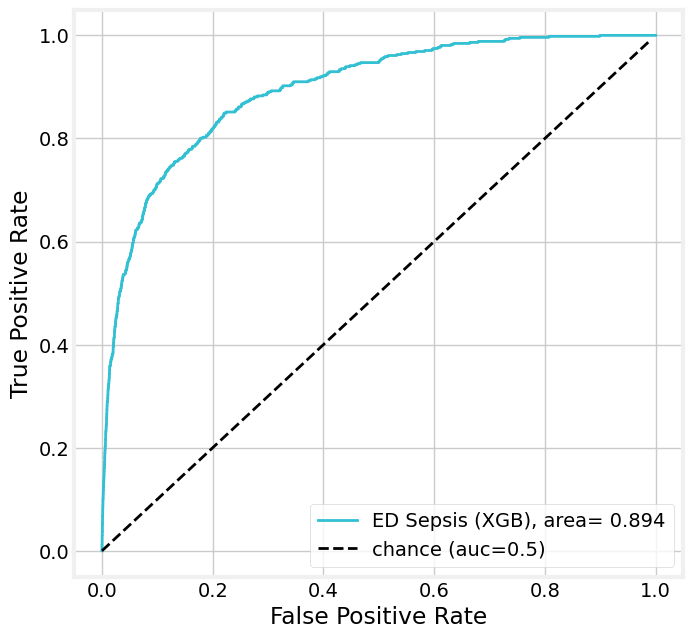

In [21]:
plt.style.use('./CEIH.mplstyle')
fig, ax = plt.subplots(figsize=(7, 7), facecolor='#FFF' )

# best_model = best_model_RandomForest

y_preds=best_model.predict (X_valid)

y_preds_proba=best_model.predict_proba (X_valid)
# select positive class 
yprobs = np.delete(y_preds_proba,[0],1)
yprobs2 = np.ravel(yprobs,order='c') 

y2=np.ravel(y_valid,order='c')

fpr, tpr, thresholds = roc_curve(y_valid, yprobs)
val,idx = find_nearest(tpr,0.85)
# print(val,tpr[idx],fpr[idx],thresholds[idx])
threshold = np.interp(0.85,tpr,thresholds)  
false_positive =  np.interp(0.85,tpr,fpr)      # fpr[idx]
print("False positive rate for ED Sepsis is {:.2%}".format(false_positive))

auc = roc_auc_score(y_valid, yprobs)
plt.plot(fpr,tpr,label="ED Sepsis ({}), area= {:.3f}".format(ModelChoice, auc))


x = np.arange(0,1,0.01)
plt.plot(x,x,label='chance (auc=0.5)',color='k',linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
# plt.savefig("Figures/{}_{}_{}_AUC_Plot.png".format(DiagnosisString,tmpString,DataSet), dpi=300, bbox_inches = "tight", facecolor=fig.get_facecolor())

plt.show()

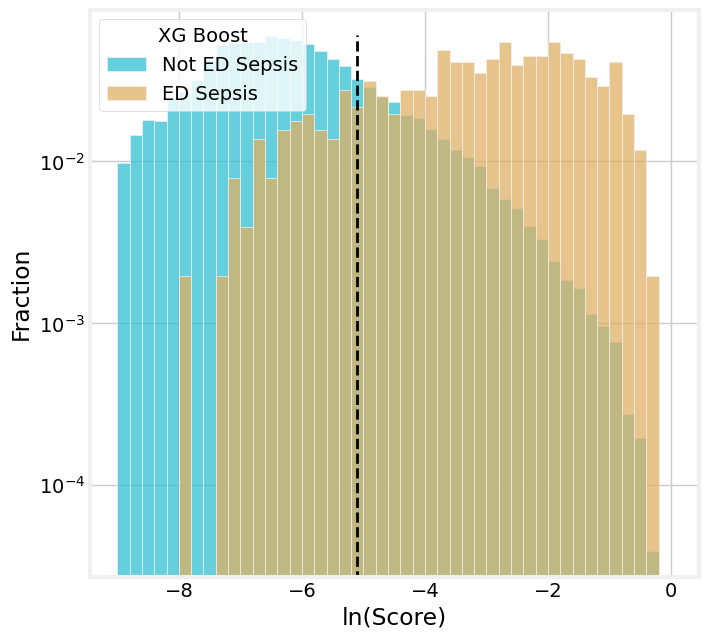

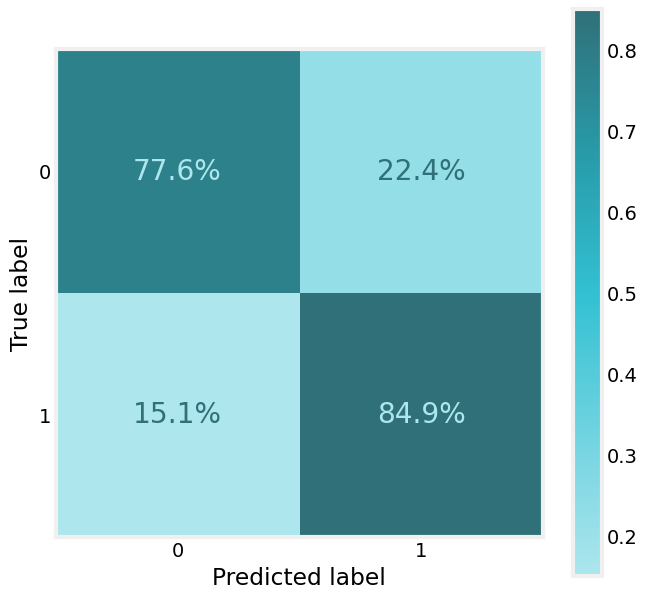

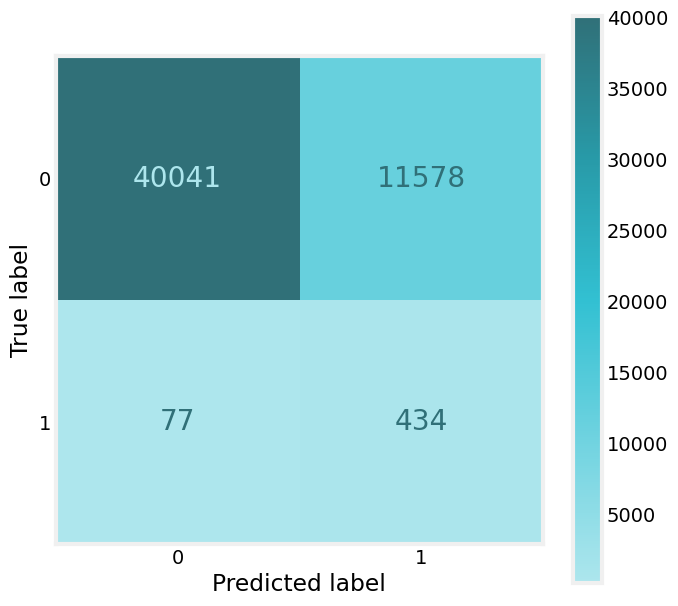

In [22]:
Diagnosis = 'ED Sepsis'
yprobs2 = np.ravel(yprobs,order='c') 

compareResults = pd.DataFrame({DiagnosisString:y2, "Prob":yprobs2})
compareResults.describe()


ResultsFlag0 = compareResults.loc[compareResults[DiagnosisString]==0]
ResultsFlag1 = compareResults.loc[compareResults[DiagnosisString]==1]


yprobslog2 = np.log(yprobs2) 

compareResultsLog = pd.DataFrame({DiagnosisString:y2, "Prob":yprobslog2})
#print(compareResultsLog.describe())


ResultsFlag0_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==0]
ResultsFlag1_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==1]
fig, ax = plt.subplots(figsize=(7, 7))


sns.histplot(data=ResultsFlag0_xgb_log, x="Prob",  binrange=[-9,0.], binwidth=0.2, stat = 'probability',label='Not {}'.format(Diagnosis))
sns.histplot(data=ResultsFlag1_xgb_log, x="Prob",  binrange=[-9,0.], binwidth=0.2,  stat = 'probability',  color= "#E0B165" , label='{}'.format(Diagnosis))
plt.legend(loc=2,  title="XG Boost")
plt.ylabel("Fraction")

y = np.arange(0.,ax.get_ylim()[1],0.01)
#print(len(y))
x =  np.full(shape = len(y), fill_value = np.log(threshold))

plt.plot(x,y,label='chance (auc=0.5)',color='k',linestyle='--')
plt.ylabel("Fraction")
plt.xlabel("ln(Score)")
plt.yscale('log')



y_preds2 = np.where(yprobs2<threshold,0,1)

# fig, ax = plt.subplots(figsize=(7, 7))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, y_preds2, normalize='true')
    )
fig, ax = plt.subplots(figsize=(7,7))
cmp.plot(cmap=cmap_blended, ax=ax, text_kw={'fontsize':'x-large'},values_format='.1%',)
ax.grid(False)


cmp2 = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, y_preds2, normalize=None)
    )
fig, ax = plt.subplots(figsize=(7,7))
cmp2.plot(cmap=cmap_blended, ax=ax, text_kw={'fontsize':'x-large'},values_format='.0f')
ax.grid(False)

In [23]:
best_model[1].feature_importances_
feat_importances=pd.Series(best_model[1].feature_importances_ , index=all_cols)
feat_importances=pd.DataFrame(feat_importances).reset_index()
feat_importances.columns=['feature', 'feature_importance']
feat_importances.sort_values('feature_importance',inplace=True,ascending=False)

feat_importances

,feature,feature_importance
5,Respiration (breaths/min),0.179587
3,O2 Flow (L/min),0.179453
2,BP Systolic (mm Hg),0.163658
7,AGEONADMIT,0.143110
1,Temperature (degrees C),0.136281
4,Sedation Score,0.095422
0,Pulse Rate (beats/min),0.069585
6,SpO2 (%),0.032905


In [24]:
feat_importances['name'] = None
idx = feat_importances.index

In [25]:
for i in idx:
    # print(i)

    val = feat_importances.loc[i].feature
    # print(i,val)
    try:
        tmpValue = plotSettings[val][4]
        end = tmpValue.rfind(' [')
        # print(end)
        if (end > 0): 
            feat_importances.at[i,'name']= tmpValue[0:tmpValue.rfind(' [')]
        else:
            feat_importances.at[i,'name']= tmpValue
    except: 
        for item9 in OtherValues.keys():
            if val == item9:
                feat_importances.at[i,'name'] = OtherValues[item9]

In [26]:
idx

Index([5, 3, 2, 7, 1, 4, 0, 6], dtype='int64')

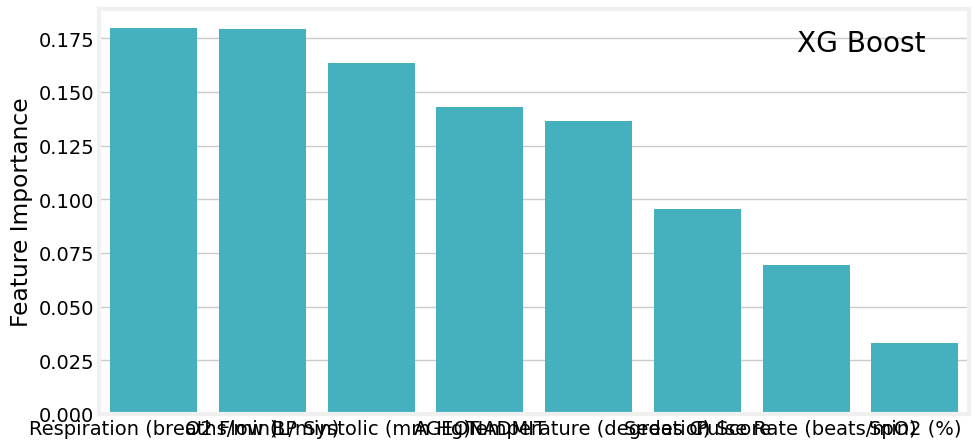

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

#plt.figure(figsize=(10,5))
chart=sns.barplot(x='feature', y='feature_importance', data=feat_importances, 
                    order=feat_importances.sort_values('feature_importance', ascending=False).feature, ax=ax
) #color='b')

# print(chart.get_xticklabels())
# chart.set_xticklabels(chart.get_xticklabels(),rotation=90, 
#                     horizontalalignment='right',fontweight='light', fontsize='x-large')

# chart.set_xticklabels( list(feat_importances['name'].values),
#                       rotation=90, ha="center",
#                    fontweight='light', fontsize='x-large')
# plt.title("feature Importance: {a} {b}".format(a=key,  b=str("Stuff")+': having All Dx'))
plt.ylabel("Feature Importance")
chart.set(xlabel=None)

ax.annotate('{}'.format(tmpString), xy=(0.95, 0.95), xycoords='axes fraction',
            fontsize='x-large', ha='right', va='top')
            #size=14, 
            # ha='right', va='top',
            #bbox=dict(boxstyle='round', fc='w'))
# plt.savefig("Figures/{}_{}_{}_Feature_Importance.png".format(DiagnosisString,tmpString,DataSet), dpi=300, bbox_inches = "tight")

plt.show()


In [28]:
best_model[1].get_booster().feature_names = list(X.columns)

In [29]:
best_model[1].get_booster().feature_names
print(best_model[1].get_booster().num_features())



8


In [30]:
fscores=pd.Series(best_model[1].get_booster().get_fscore() , index=all_cols)
fscores
best_model[1].feature_importances_

array([0.06958478, 0.136281  , 0.16365823, 0.17945313, 0.09542166,
       0.1795866 , 0.03290467, 0.14310989], dtype=float32)

In [31]:
best_model[1].get_booster().get_fscore()

{'Pulse Rate (beats/min)': 1179.0,
 'Temperature (degrees C)': 1178.0,
 'BP Systolic (mm Hg)': 1189.0,
 'O2 Flow (L/min)': 355.0,
 'Sedation Score': 168.0,
 'Respiration (breaths/min)': 684.0,
 'SpO2 (%)': 603.0,
 'AGEONADMIT': 1036.0}

In [32]:
# best_model[1].get_booster().feature_names = list(X.columns)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

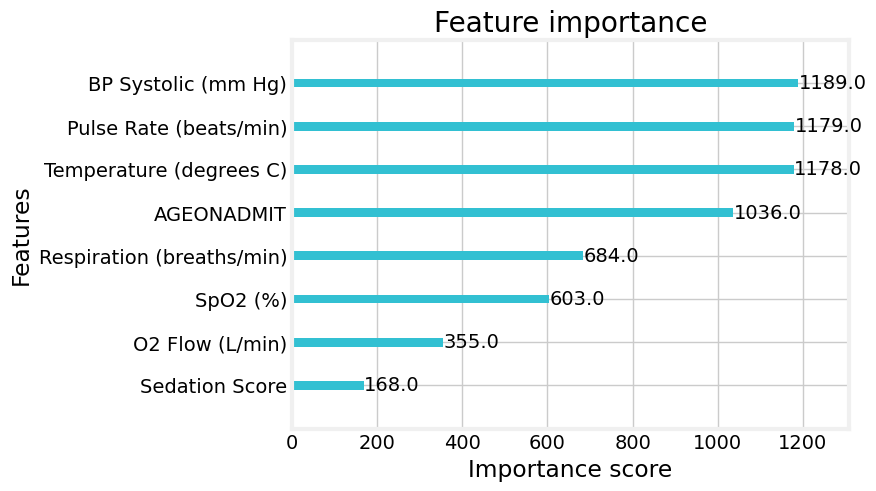

In [33]:
xgb.plot_importance(best_model[1],importance_type="weight")


In [34]:
print((X.columns))

Index(['Pulse Rate (beats/min)', 'Temperature (degrees C)',
       'BP Systolic (mm Hg)', 'O2 Flow (L/min)', 'Sedation Score',
       'Respiration (breaths/min)', 'SpO2 (%)', 'AGEONADMIT'],
      dtype='object')
